# Introduction
**1. Obtaining and Organizing Datasets**

**2. Image Augmentation**

**3. Reading the Dataset**

**4. Fine-Tuning the pretrained model**

**5. Defining the Training Function**

**6. Training and Validating the Model**

**7. Classifying the Testing Set and Submitting Results on Kaggle**

In [1]:
import os
import torch, torchvision
from torch import nn
from d2l import torch as d2l

# 1. Obtaining and Organizing Dataset

The competition dataset is divided into a training set and a test set, which contain 10222 and 10357 JPEG images of three RGB (color) channels, respectively.

Among the training dataset, there are 120 breeds of dogs such as Labradors, Poodles, Dachshunds, Samoyeds, Huskies, Chihuahuas, and Yorkshire Terriers.

## 1.1 Downloading the Dataset

In [2]:
d2l.DATA_HUB['dog_tiny'] = (d2l.DATA_URL + 'kaggle_dog_tiny.zip',
                            '0cb91d09b814ecdc07b50f31f8dcad3e81d6a86d')

# If you use the full dataset downloaded for the Kaggle competition, change
# the variable below to `False`
demo = True
if demo:
    data_dir = d2l.download_extract('dog_tiny')
else:
    data_dir = os.path.join('..', 'data', 'dog-breed-identification')

##  1.2 Organizing the Dataset

In [3]:
def reorg_dog_data(data_dir, valid_ratio):
    labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv'))
    d2l.reorg_train_valid(data_dir, labels, valid_ratio)
    d2l.reorg_test(data_dir)


batch_size = 32 if demo else 128
valid_ratio = 0.1
reorg_dog_data(data_dir, valid_ratio)

# 2. Image Augmentation

In [5]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(3/4, 4/3)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])
])

In [6]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    # Crop a 224 x 224 square area from the center of the image
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

# 3. Reading the Dataset

In [7]:
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

In [8]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

# Fine-Tuning a Pretrained Model

Again, the dataset for this competition is a subset of the ImageNet dataset. Therefore, we can use the approach discussed in Section 14.2 to select a model pretrained on the full ImageNet dataset and use it to extract image features to be fed into a custom small-scale output network.

High-level APIs of deep learning frameworks provide a wide range of models pretrained on the ImageNet dataset. Here, we choose a pretrained ResNet-34 model, where we simply reuse the input of this model’s output layer (i.e., the extracted features).

 Then we can replace the original output layer with a small custom output network that can be trained, such as stacking two fully connected layers.

Different from the experiment in Section 14.2, the following does not retrain the pretrained model used for feature extraction. This reduces training time and memory for storing gradients.

Recall that we standardized images using the means and standard deviations of the three RGB channels for the full ImageNet dataset. In fact, this is also consistent with the standardization operation by the pretrained model on ImageNet.

In [9]:
def get_net(devices):
    finetune_net = nn.Sequential()
    finetune_net.features = torchvision.models.resnet34(weights='ResNet34_Weights.IMAGENET1K_V1')
    # Define a new output network (there are 120 output categories)
    finetune_net.output_new = nn.Sequential(nn.Linear(1000, 256),
                                            nn.ReLU(),
                                            nn.Linear(256, 120))
    finetune_net = finetune_net.to(devices[0])
    # Freeze paremeters of features layers:
    for params in finetune_net.features.parameters():
        params.requires_grad = False
    return finetune_net

Before calculating the loss, we first obtain the input of the pretrained model’s output layer, i.e., the extracted feature. Then we use this feature as input for our small custom output network to calculate the loss.

In [10]:
loss = nn.CrossEntropyLoss(reduction='none')

def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        features, labels = features.to(devices[0]), labels.to(devices[0])
        output = net(features)
        l = loss(output, labels)
        l_sum += l.sum()
        n += labels.numel()
        return l_sum / n

# 5. Defining the Training Function

We will select the model and tune hyper-parameters according to the model’s performance on the validation set. The model training function train only iterates parameters of the small custom output network.

In [18]:
def train(net, train_loader, val_loader, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    # only train  the small custom output network
    # 1. model
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    # 2. optimizer
    trainer = torch.optim.SGD(params=[param for param in net.parameters() if param.requires_grad], lr = lr, momentum=0.9, weight_decay=wd)
    # 3. Scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_loader), d2l.Timer()

    legend = ['train loss']
    if val_loader is not None:
        legend.append('val loss')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=legend)

    for epoch in range(num_epochs):
        metric  = d2l.Accumulator(2)

        for i, (features, labels) in enumerate(train_loader):
            timer.start()
            # 1. get a batch of train data,  and move to devices
            features, labels = features.to(devices[0]), labels.to(devices[0])
            # 2. zero grad the optimizer
            trainer.zero_grad()
            # 3. perform inference
            outputs = net(features)
            l = loss(outputs, labels).sum()
            # perform backward
            l.backward()
            # tell the optimizer to adjust learning weight -> step method
            trainer.step()
            metric.add(l, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1], None))
        measures = f'train loss {metric[0] / metric[1]:.3f}'
        if valid_iter is not None:
            valid_loss = evaluate_loss(valid_iter, net, devices)
            animator.add(epoch + 1, (None, valid_loss.detach().cpu()))
        scheduler.step()
    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'
    print(measures + f'\n{metric[1] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')



# Training and Validating the Model

train loss 0.404, valid loss 1.292
264.9 examples/sec on [device(type='cuda', index=0)]


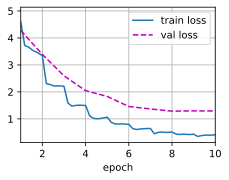

In [19]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 10, 1e-4, 1e-4
lr_period, lr_decay, net = 2, 0.9, get_net(devices)
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

# Classifying the Testing Set and Submitting Results on Kaggle

train loss 0.363, valid loss 0.310
382.2 examples/sec on [device(type='cuda', index=0)]


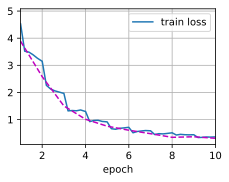

In [20]:
net = get_net(devices)
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

preds = []
for data, label in test_iter:
    output = torch.nn.functional.softmax(net(data.to(devices[0])), dim=1)
    preds.extend(output.cpu().detach().numpy())
ids = sorted(os.listdir(
    os.path.join(data_dir, 'train_valid_test', 'test', 'unknown')))
with open('submission.csv', 'w') as f:
    f.write('id,' + ','.join(train_valid_ds.classes) + '\n')
    for i, output in zip(ids, preds):
        f.write(i.split('.')[0] + ',' + ','.join(
            [str(num) for num in output]) + '\n')

# Summary
1. Images in the ImageNet dataset are larger (with varying dimensions) than CIFAR-10 images. We may modify image augmentation operations for tasks on a different dataset
2. To classify a subset of the ImageNet dataset, we can leverage pre-trained models on the full ImageNet dataset to extract features and only train a custom small-scale output network. This will lead to less computational time and memory cost.